In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from entmax import sparsemax  # Requires: pip install entmax


/home/rsarkar/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Price prediction and portfolio grwth curve

In [3]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------
# Data Preprocessing
# ------------------------
def load_and_preprocess_data(file_paths, seq_len=10, date_column='Date', feature_columns=['Open', 'Close', 'High', 'Low']):
    dfs = []
    for file in file_paths:
        if not os.path.exists(file):
            print(f"Error: File {file} not found.")
            continue
        try:
            df = pd.read_excel(file)
            df.columns = df.columns.str.strip().str.lower()
            required_columns = [date_column.lower()] + [col.lower() for col in feature_columns]

            def convert_date(date):
                try:
                    if isinstance(date, (int, float)):
                        base_date = datetime(1899, 12, 30)
                        return pd.to_datetime(base_date + timedelta(days=date))
                    elif isinstance(date, pd.Timestamp):
                        return date
                    else:
                        return pd.to_datetime(date, errors='coerce')
                except Exception as e:
                    print(f"Error parsing date in {file}: {e}")
                    return pd.NaT

            df['date'] = df['date'].apply(convert_date)
            df = df.set_index('date')

            for col in feature_columns:
                df[col.lower()] = df[col.lower()].round(2)

            if 'volume' in df.columns:
                df = df[df['volume'] != 0]
                df = df.drop(columns=['volume'])

            df = df[required_columns[1:]].dropna()
            if df.empty:
                print(f"Warning: No valid data after preprocessing for {file}.")
                continue
            dfs.append(df)
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    if not dfs:
        raise ValueError("No valid dataframes loaded from provided files.")

    common_dates = pd.concat([df[['close']] for df in dfs], axis=1).dropna().index
    if common_dates.empty:
        raise ValueError("No common dates found across assets.")

    dfs = [df.loc[common_dates] for df in dfs]

    data = np.stack([df[[col.lower() for col in feature_columns]].values for df in dfs], axis=1)
    sequences = [data[i:i + seq_len] for i in range(len(data) - seq_len + 1)]
    if not sequences:
        raise ValueError("No sequences generated. Check data length and sequence length.")
    sequences = torch.tensor(np.array(sequences), dtype=torch.float32).to(device)
    print(f"Final test sequence tensor shape: {sequences.shape}")
    return sequences

# ------------------------
# DCC Layer
# ------------------------
class DCC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(DCC, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=(kernel_size - 1) * dilation, dilation=dilation)
        self.kernel_size = kernel_size
        self.dilation = dilation

    def forward(self, x):
        x = self.conv(x)
        padding = (self.kernel_size - 1) * self.dilation
        x = x[:, :, :-padding] if padding > 0 else x
        return F.relu(x)

# ------------------------
# GAT Layer
# ------------------------
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(GATLayer, self).__init__()
        self.Wg = nn.Linear(in_features, out_features, bias=False)
        self.Wa = nn.Linear(2 * in_features, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, node_features, edge_info):
        batch_size, num_nodes, in_features = node_features.size()
        h = self.Wg(node_features)

        attention = torch.zeros(batch_size, num_nodes, num_nodes, device=node_features.device)
        for i in range(num_nodes):
            for j in range(num_nodes):
                concat_features = torch.cat([node_features[:, i, :], node_features[:, j, :]], dim=-1)
                gate = torch.tanh(self.Wa(concat_features))
                attention[:, i, j] = edge_info[:, i, j] * gate.squeeze()

        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)

        h_prime = torch.bmm(attention, h)
        return F.elu(h_prime)

# ------------------------
# Portfolio Optimization Model
# ------------------------
class PortfolioOptimization(nn.Module):
    def __init__(self, num_assets, num_features=4, hidden_dim=128, input_seq_len=9):
        super(PortfolioOptimization, self).__init__()
        self.num_assets = num_assets
        self.hidden_dim = hidden_dim
        self.input_seq_len = input_seq_len
        
        # Feature extraction
        self.dcc1 = DCC(num_features, hidden_dim, kernel_size=3, dilation=1)
        self.dcc2 = DCC(hidden_dim, hidden_dim, kernel_size=3, dilation=2)
        self.dcc3 = DCC(hidden_dim, hidden_dim, kernel_size=3, dilation=4)

        # Attention mechanism
        self.Wq = nn.Linear(num_features * input_seq_len, hidden_dim)
        self.Wk = nn.Linear(num_features * input_seq_len, hidden_dim)
        self.Wv = nn.Linear(num_features * input_seq_len, hidden_dim)

        # Graph attention
        self.gat = GATLayer(hidden_dim, hidden_dim)

        # Feature combination
        self.Wr = nn.Linear(hidden_dim, hidden_dim)
        self.We = nn.Linear(hidden_dim, hidden_dim)

        # Prediction head
        self.dcc_pred = DCC(hidden_dim * 3, num_features, kernel_size=3, dilation=1)

        # Policy head
        self.Wf = nn.Linear(hidden_dim * 3, hidden_dim)
        self.conv_policy = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wt = nn.Linear(hidden_dim + num_features, hidden_dim)
        self.Ww = nn.Linear(hidden_dim, num_assets)

        # Allocation parameters
        self.min_weight = 0.05
        self.rank_power = 1.0
        self.temperature = nn.Parameter(torch.tensor(1.0))  # Learnable temperature
        self.price_scale = nn.Parameter(torch.ones(num_features))
        self.price_bias = nn.Parameter(torch.zeros(num_features))

    def forward(self, x, prev_weights=None):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        batch_size, seq_len, num_assets, num_features = x.size()
    
        # Feature extraction
        x_reshaped = x.permute(0, 2, 3, 1).reshape(batch_size * num_assets, num_features, seq_len)
        fe = self.dcc1(x_reshaped)
        fe = self.dcc2(fe)
        fe = self.dcc3(fe)
        fe = fe[:, :, -1].reshape(batch_size, num_assets, self.hidden_dim)
    
        # Cross-asset attention
        patches_flat = x.reshape(batch_size, num_assets, -1)
        q = self.Wq(patches_flat)
        k = self.Wk(patches_flat)
        v = self.Wv(patches_flat)
        attention = torch.bmm(q, k.transpose(1, 2)) / (self.hidden_dim ** 0.5)
        attention = F.softmax(attention, dim=-1)
    
        # Graph attention
        fr = self.gat(fe, attention)
    
        # Market context
        fm = self.Wr(fr) + self.We(fe)
        fm = fm.mean(dim=1, keepdim=True).expand(-1, num_assets, -1)
    
        # Combined features
        f = torch.cat([fe, fr, fm], dim=-1)
        f_reshaped = f.permute(0, 2, 1)
        x_pred = self.dcc_pred(f_reshaped)
        x_pred = x_pred.permute(0, 2, 1)
        
        # Ensure positive predictions using modified softplus
        x_pred = F.softplus(x_pred) * 1.5  # Scale to prevent predictions from being too small
    
        # Policy features
        f_policy = F.relu(self.conv_policy(self.Wf(f).permute(0, 2, 1))).permute(0, 2, 1)
        f_policy = self.Wt(torch.cat([f_policy, x_pred], dim=-1))
        
        if prev_weights is not None:
            f_policy = f_policy + prev_weights.unsqueeze(-1)
    
        # Raw score for allocation
        raw_scores = self.Ww(f_policy[:, -1])  # shape: [B, A]
        
        # Get predicted returns from the Close prices (index 1 in features)
        predicted_returns = x_pred[:, :, 1]  # shape: [B, A]
        
        # Combine raw scores with predicted returns for ranking
        combined_scores = raw_scores + predicted_returns.detach()  # Detach to prevent double counting
        
        # Create differentiable rank weights
        ranks = torch.argsort(torch.argsort(combined_scores, dim=1, descending=True))
        rank_weights = 1.0 / (ranks.float() + 1)  # 1/rank weighting
        
        # Normalize rank weights
        rank_weights = rank_weights / rank_weights.sum(dim=1, keepdim=True)
        
        # Apply temperature-scaled sparsemax to combined scores
        scaled_scores = combined_scores / (self.temperature + 1e-8)
        sparse_weights = sparsemax(scaled_scores, dim=-1)
        
        # Blend sparse weights with rank weights
        weights = 0.7 * sparse_weights + 0.3 * rank_weights
        
        # Apply min allocation constraint and normalize
        weights = self.min_weight + (1.0 - self.min_weight * num_assets) * weights
        weights = weights / weights.sum(dim=1, keepdim=True)
        
        return x_pred, weights



Final test sequence tensor shape: torch.Size([28, 10, 6, 4])
✅ Model loaded.

Stock: BPCL
MSE (Open, Close, High, Low): [34.1206 50.5308 38.7417 39.0018]


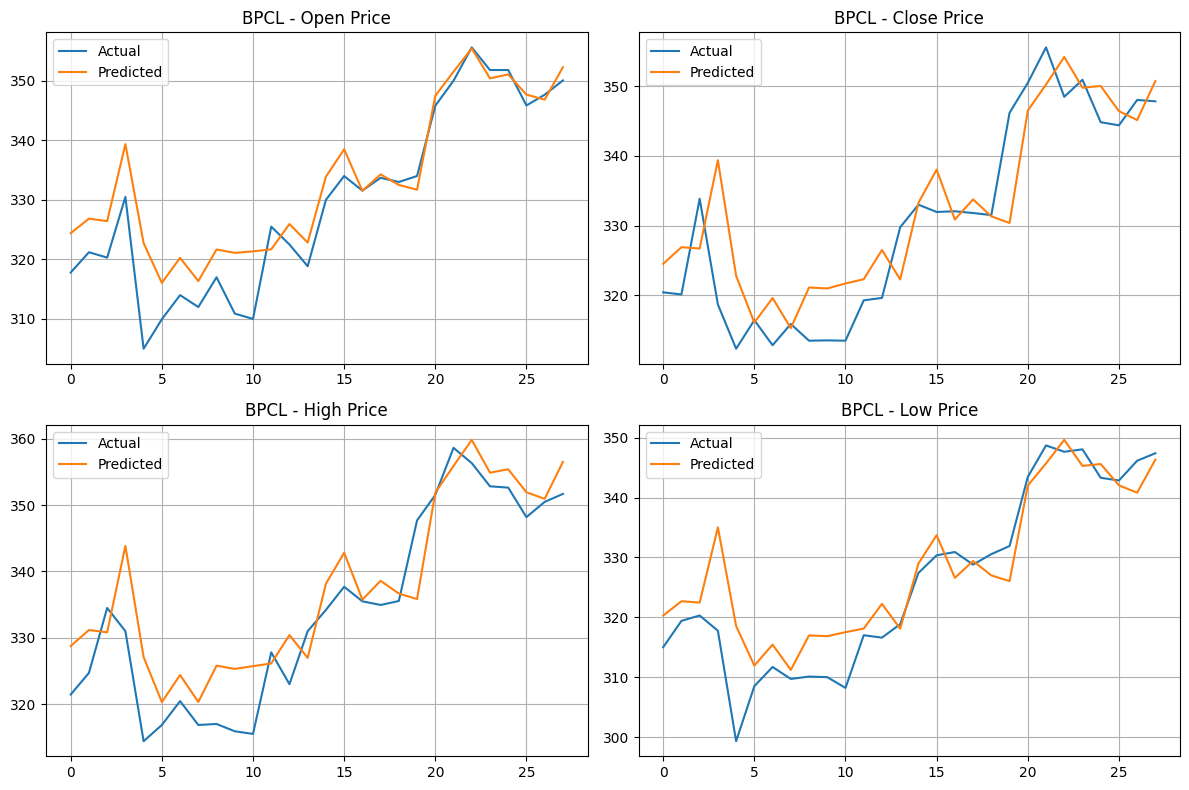


Stock: IOC
MSE (Open, Close, High, Low): [22.595  22.6388 22.9373 15.6241]


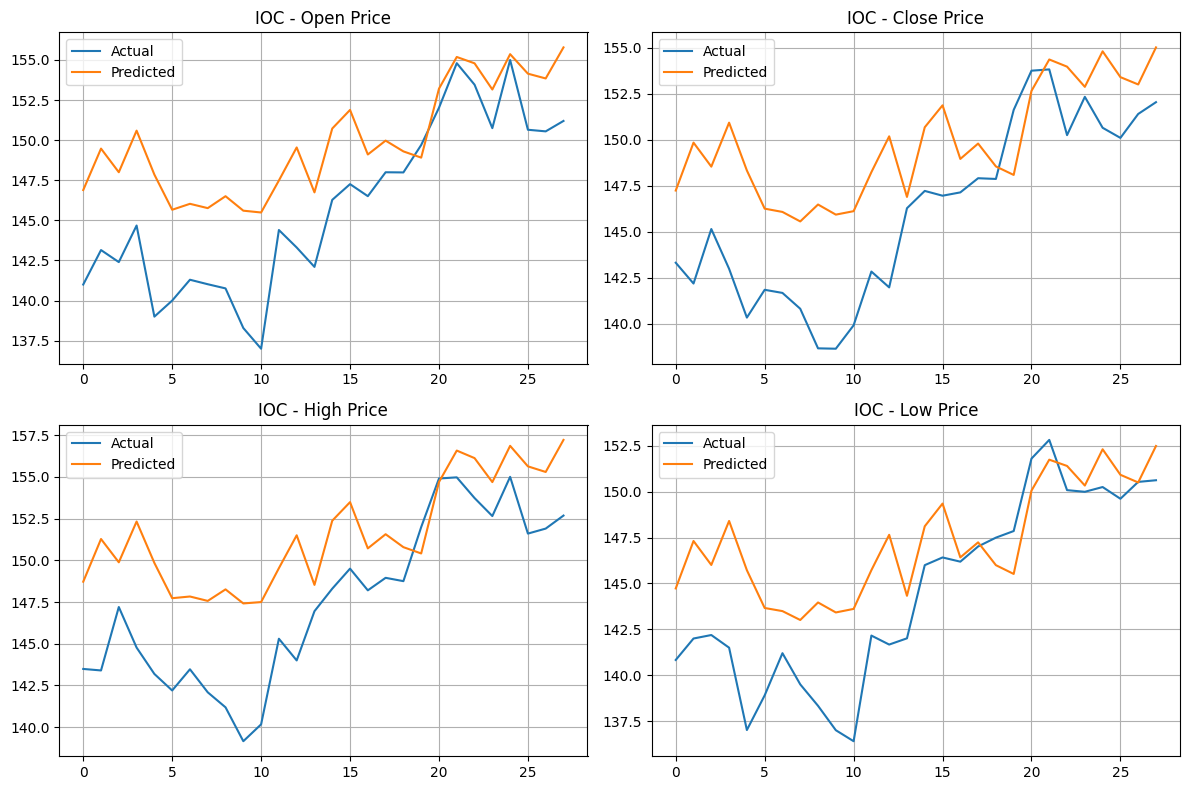


Stock: HINDPETRO
MSE (Open, Close, High, Low): [60.6575 99.837  68.8979 71.2948]


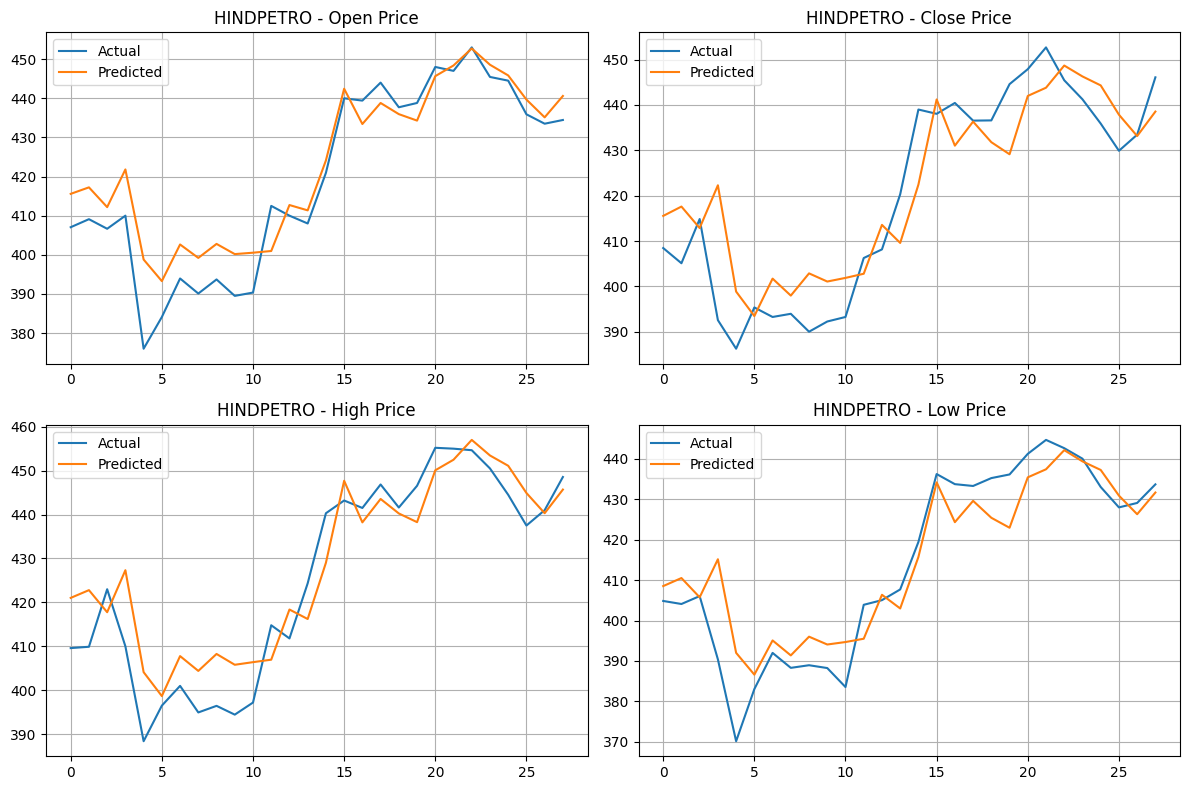


Stock: NMDC
MSE (Open, Close, High, Low): [5.153  4.9241 4.0339 1.956 ]


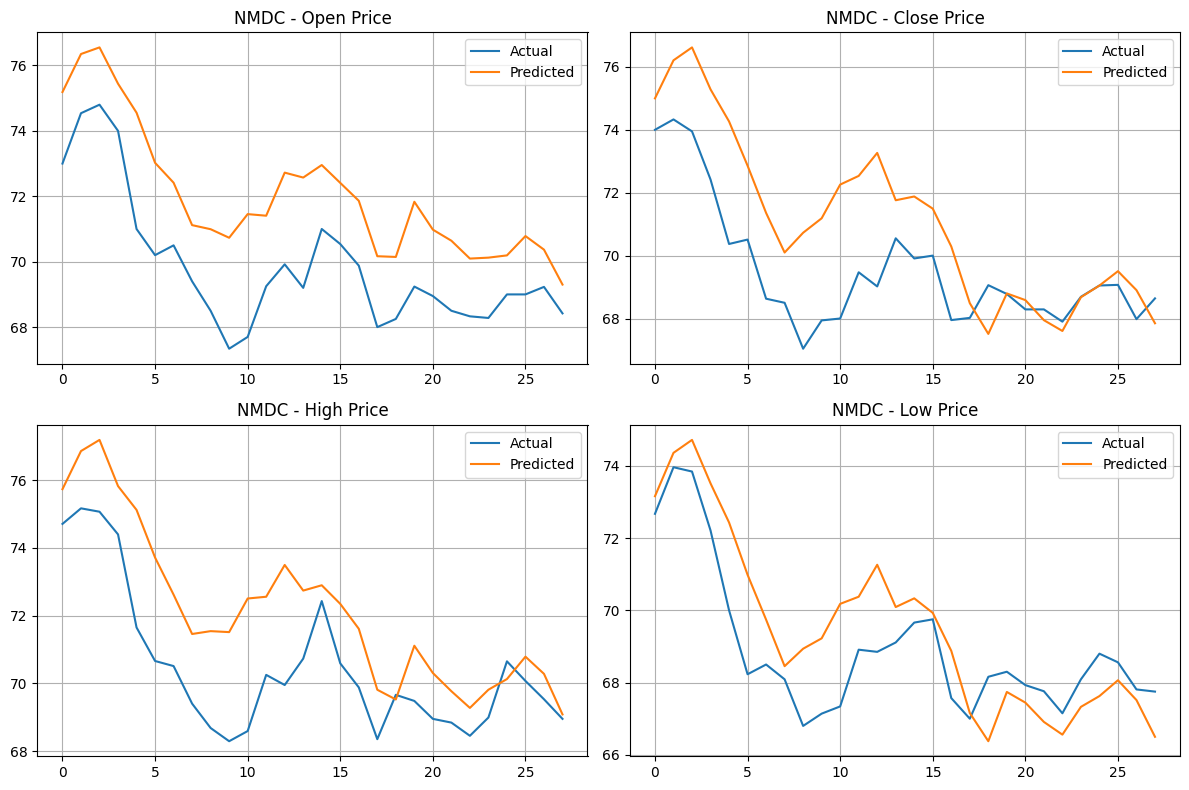


Stock: ONGC
MSE (Open, Close, High, Low): [15.1749 29.2784 26.0336  9.1923]


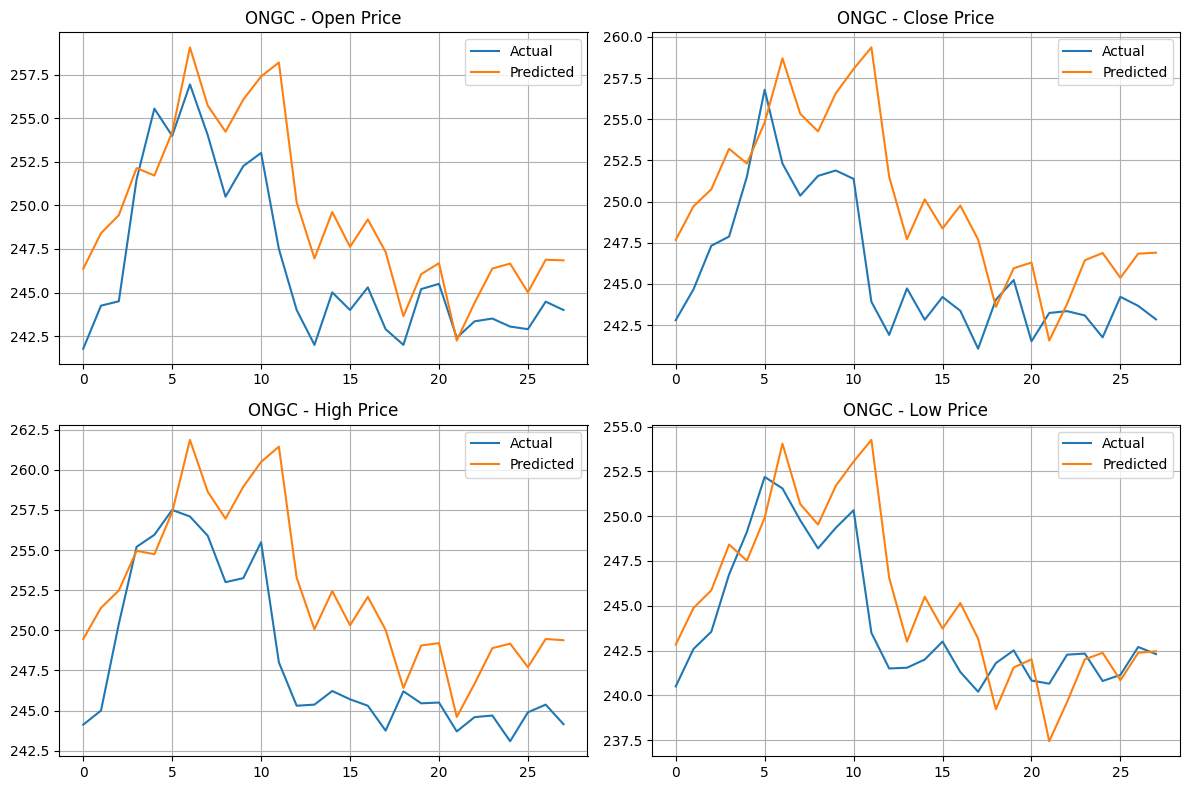


Stock: IRFC
MSE (Open, Close, High, Low): [11.0477 11.5702  9.4114  7.2119]


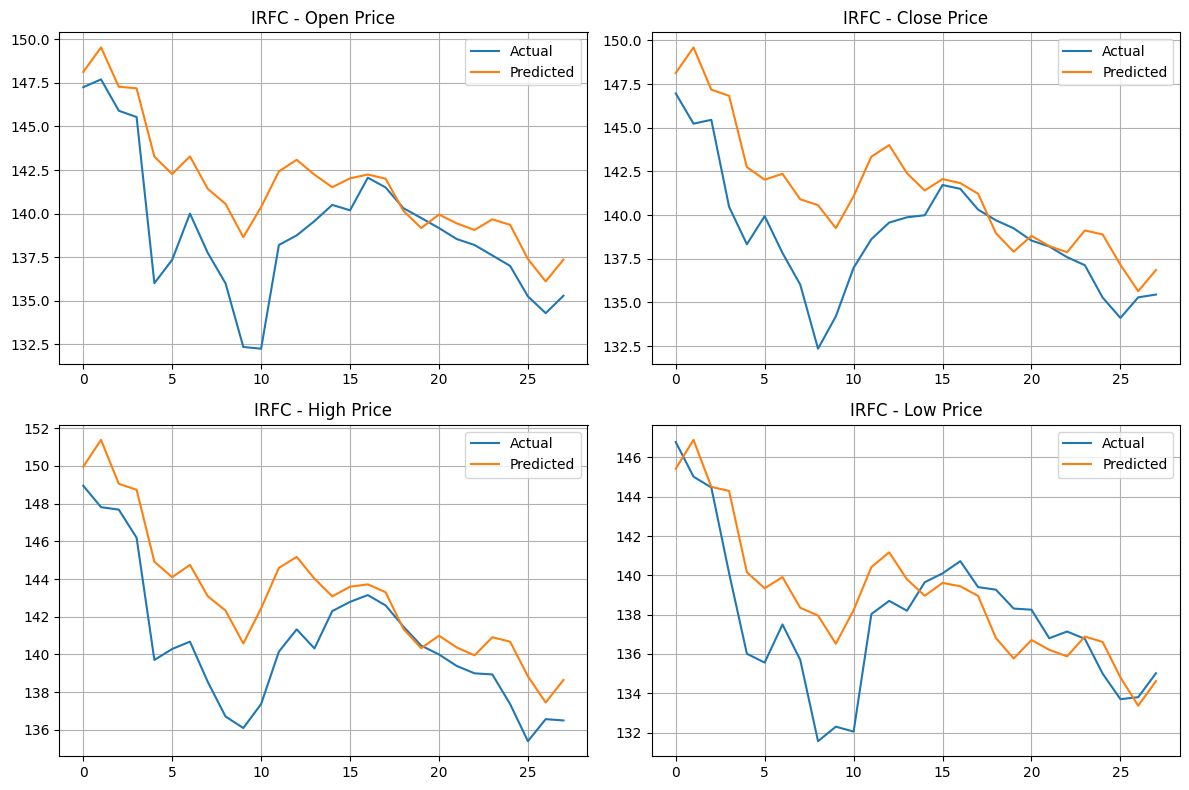

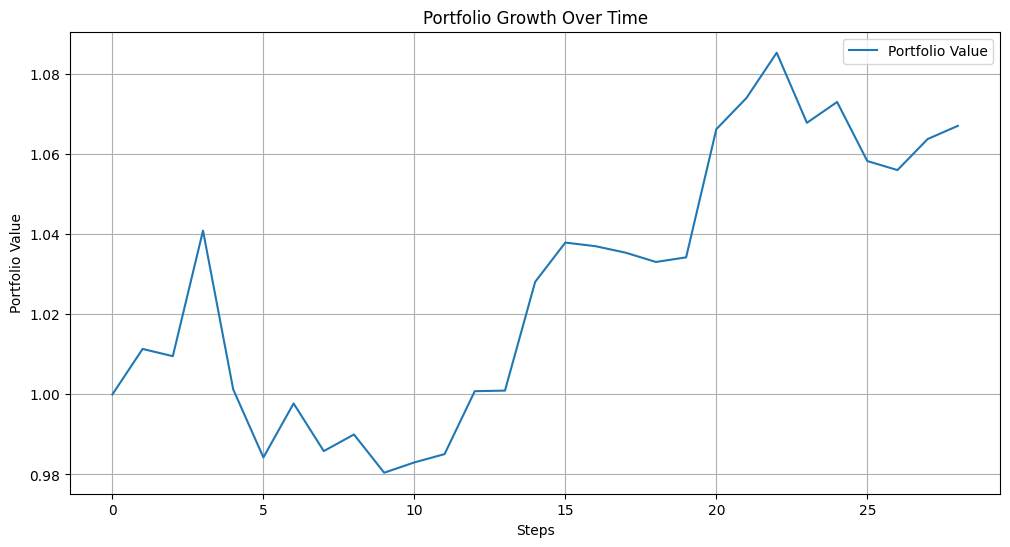

In [4]:
# ------------------------
# Evaluation
# ------------------------
def evaluate_model(model, test_sequences, stock_names):
    model.eval()
    actual_prices, predicted_prices = [], []
    portfolio_values = [1.0]  # Initial portfolio value
    prev_weights = None
    epsilon = 1e-8  # For numerical stability

    with torch.no_grad():
        for batch in test_sequences:
            x_input = batch[:-1].unsqueeze(0)
            target = batch[1:].unsqueeze(0)[:, -1]

            x_pred, weights = model(x_input, prev_weights)
            actual_prices.append(target[0].cpu().numpy())
            predicted_prices.append(x_pred[0].cpu().numpy())

            relative_prices = target[:, :, 1] / (batch[-2, :, 1] + epsilon)
            portfolio_return = torch.sum(relative_prices * weights, dim=-1).item()
            portfolio_return = max(portfolio_return, 0.0)  # Prevent negative returns
            portfolio_values.append(portfolio_values[-1] * portfolio_return)

            prev_weights = weights.detach()

    actual_prices = np.stack(actual_prices)
    predicted_prices = np.stack(predicted_prices)

    mse = ((actual_prices - predicted_prices) ** 2).mean(axis=0)
    for i, stock in enumerate(stock_names):
        print(f"\nStock: {stock}")
        print("MSE (Open, Close, High, Low):", mse[i].round(4))

        # Plot all features for the stock in one figure
        plt.figure(figsize=(12, 8))
        for j, label in enumerate(['Open', 'Close', 'High', 'Low']):
            plt.subplot(2, 2, j+1)
            plt.plot(actual_prices[:, i, j], label='Actual')
            plt.plot(predicted_prices[:, i, j], label='Predicted')
            plt.title(f"{stock} - {label} Price")
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Growth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# Main
# ------------------------
def main():
    test_paths = [
        r'testing/bpcl200d.xlsx',
        r'testing/ioc200d.xlsx',
        r'testing/hindpetro200d.xlsx',
        r'testing/nmdc200d.xlsx',
        r'testing/ongc200d.xlsx',
        r'testing/irfc200d.xlsx'
    ]
    stock_names = ['BPCL', 'IOC', 'HINDPETRO', 'NMDC', 'ONGC', 'IRFC']
    num_assets=len(test_paths)
    seq_len = 10
    model_path = 'rl_portfolio_optimization.pth'

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")

    test_sequences = load_and_preprocess_data(test_paths, seq_len=seq_len)

    model = PortfolioOptimization(num_assets=num_assets, num_features=4, hidden_dim=128, input_seq_len=seq_len - 1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Model loaded.")

    evaluate_model(model, test_sequences, stock_names)

if __name__ == '__main__':
    main()

In [5]:
# Dynamically change of weights in each asstes

Final test sequence tensor shape: torch.Size([28, 10, 6, 4])
✅ Model loaded.

📈 Final Portfolio Value: ₹96055.12
💰 Total Profit: ₹6055.12


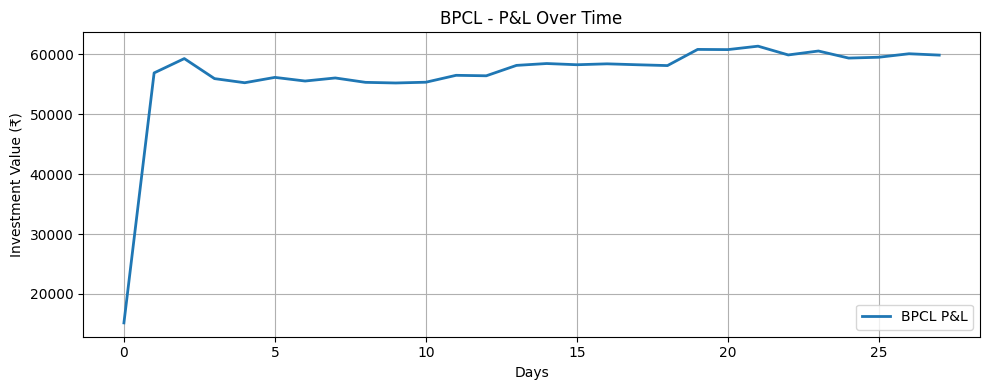

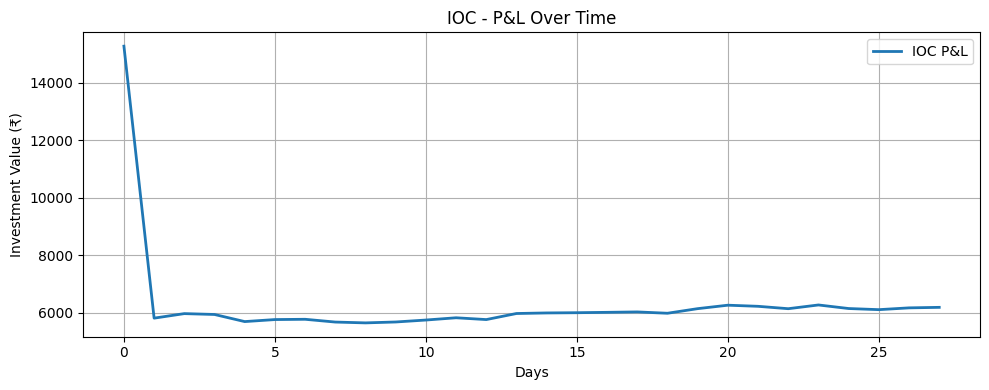

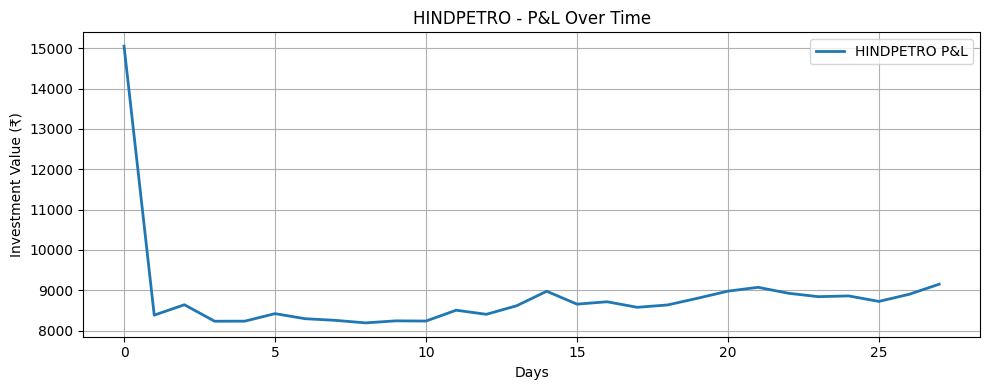

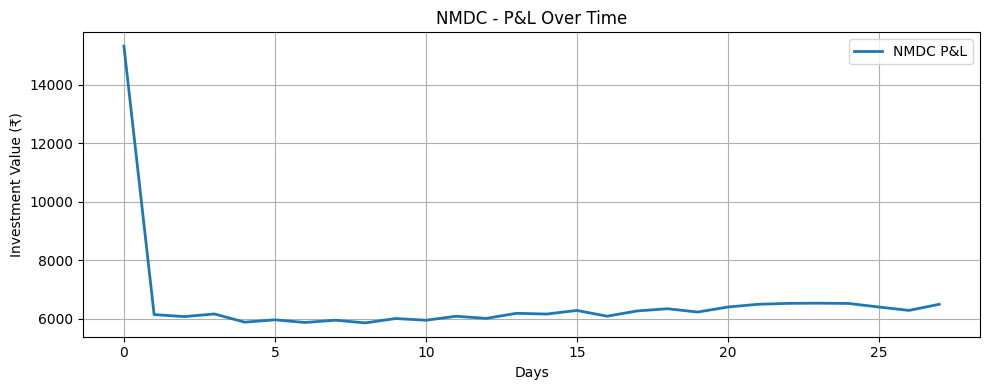

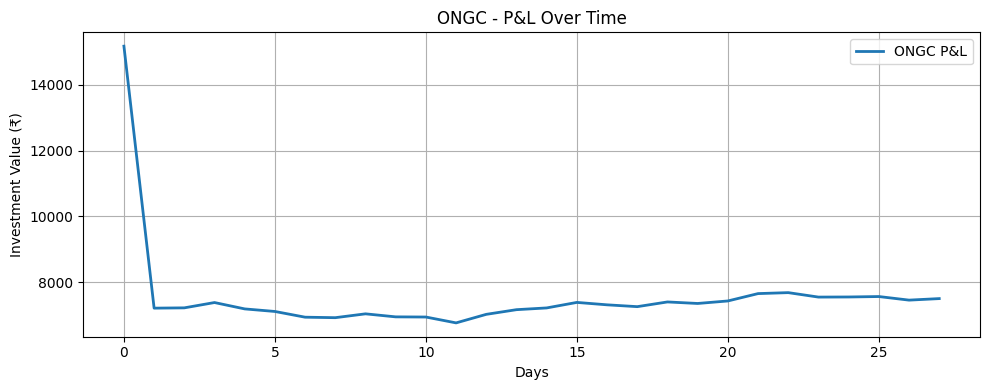

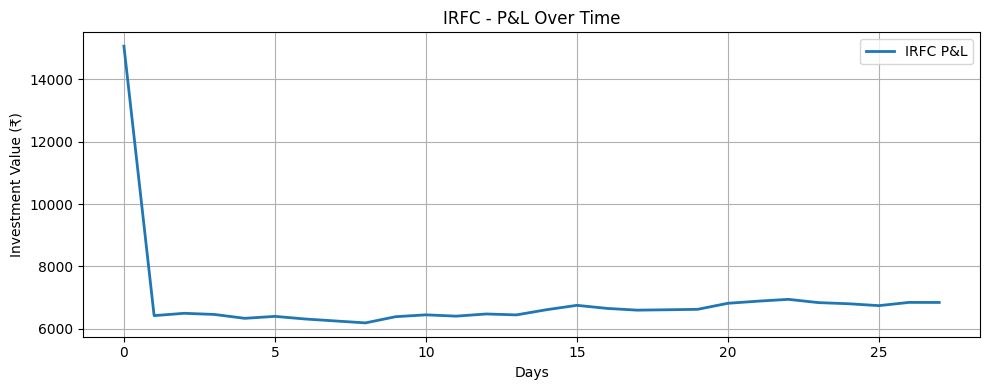

/tmp/ipykernel_4597/3920198607.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


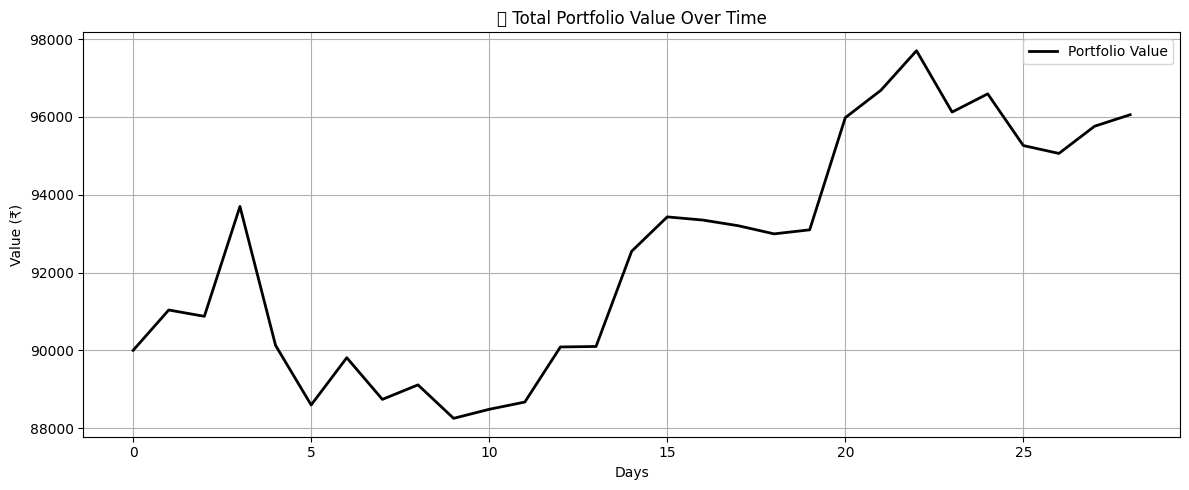

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def simulate_investment(model, test_sequences, stock_names, initial_investment=90000):
    model.eval()
    num_assets = len(stock_names)
    investment_per_stock = initial_investment / num_assets

    portfolio_values = [initial_investment]
    stock_pnl = [[] for _ in range(num_assets)]
    prev_weights = None
    current_investments = np.array([investment_per_stock] * num_assets)

    with torch.no_grad():
        for batch in test_sequences:
            x_input = batch[:-1].unsqueeze(0)
            target = batch[1:].unsqueeze(0)[:, -1]

            x_pred, weights = model(x_input, prev_weights)

            # Use 'Close' price: index 1
            prev_close = batch[-2, :, 1].cpu().numpy()  # shape: (num_assets,)
            curr_close = target[0, :, 1].cpu().numpy()  # shape: (num_assets,)

            # Compute new investment values based on price change
            price_change = curr_close / prev_close
            current_investments = current_investments * price_change

            # Store P&L for each stock
            for i in range(num_assets):
                stock_pnl[i].append(current_investments[i])

            # Compute total portfolio value and rebalance
            total_value = np.sum(current_investments)
            portfolio_values.append(total_value)

            weights_np = weights[0].cpu().numpy()
            current_investments = weights_np * total_value

            prev_weights = weights.detach()

    final_value = portfolio_values[-1]
    profit = final_value - initial_investment

    print(f"\n📈 Final Portfolio Value: ₹{final_value:.2f}")
    print(f"💰 Total Profit: ₹{profit:.2f}")

    # Plot P&L for each stock
    for i, stock in enumerate(stock_names):
        plt.figure(figsize=(10, 4))
        plt.plot(stock_pnl[i], label=f'{stock} P&L', linewidth=2)
        plt.title(f'{stock} - P&L Over Time')
        plt.xlabel('Days')
        plt.ylabel('Investment Value (₹)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot total portfolio value over time
    plt.figure(figsize=(12, 5))
    plt.plot(portfolio_values, label='Portfolio Value', color='black', linewidth=2)
    plt.title('📊 Total Portfolio Value Over Time')
    plt.xlabel('Days')
    plt.ylabel('Value (₹)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    import pandas as pd
    import torch
    from datetime import datetime, timedelta

    
    test_paths = [
        r'testing/bpcl200d.xlsx',
        r'testing/ioc200d.xlsx',
        r'testing/hindpetro200d.xlsx',
        r'testing/nmdc200d.xlsx',
        r'testing/ongc200d.xlsx',
        r'testing/irfc200d.xlsx'
    ]
    stock_names = ['BPCL', 'IOC', 'HINDPETRO', 'NMDC', 'ONGC', 'IRFC']
    seq_len = 10    
    num_assets = len(test_paths)

    # Load and preprocess test data
    test_sequences = load_and_preprocess_data(test_paths, seq_len=seq_len)

    # Load the trained model
    model = PortfolioOptimization(num_assets=num_assets, num_features=4, hidden_dim=128, input_seq_len=seq_len - 1).to(device)
    model.load_state_dict(torch.load('rl_portfolio_optimization.pth', map_location=device))
    print("✅ Model loaded.")

    # Run investment simulation
    simulate_investment(model, test_sequences, stock_names, initial_investment=90000)

if __name__ == '__main__':
    main()
